In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Exogenous introduction of new knowledge and effect on spillovers

1. Find primary classes with "software" in title
2. Merge patent with unique assignees
3. Get new firms that applied for patents for the first time in 1995-1996 (In re Alappat, July 1994 - see Hall & MacGarvie) in primary classes from 1
4. Get existing patents in primary classes from 1 applied for at same time
5. Get sample of other patents applied for 1985-2005: PRIOR patents; 1985-1995: POST patents 1995-2005. NOTE: this includes Dotcom bubble burst of 2000.
6. Get similarity calculations for all pairs for within NAICS sample

### Spillover measures

1. Measure similarity for both samples (a) within NAICS - all; (b) within primary class over time
    - Expectation: Lower for new firm patents and then higher after 2001. Higher for existing firm patents and then lower after 2001.
2. Measure localization for sample (a) within NAICS - all; (b) within primary class over time
    - Expectation: Decline in localization 1999-2000, increase after, then fall
    
### Location measures
For each primary class plus NAICS, get distribution over locations for each year
1. HHI index of location concentration time series
2. Cosine similarity of location distributions over time

In [28]:
# Merge patent with application year
# pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
# print(len(pdf))
# p2 = pd.read_pickle("RawData/HBSPatData/invpat_us_7509_loc_unique.pkl")[["patent", "appyear"]]
# pdf = pdf.merge(p2, how = "left", on = "patent")
# print(len(pdf))
# fastparquet.write("RawData/Cleaned/patent_loc_unique_us_0628.parq", pdf, compression="GZIP")

In [44]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
asg = fastparquet.ParquetFile("RawData/Cleaned/patent_assignees_unique_0628.parq").to_pandas()
pc = pd.read_table("RawData/PatentView/uspc_current.tsv")

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
# 1. Software/Data processing primary classes
pc = pd.read_table("RawData/PatentView/mainclass_current.tsv")
pc = pc.dropna(how="any")
spc = pc.loc[pc["title"].apply(lambda x: "DATA PROCESSING" in x)].copy()
spc["id"] = spc["id"].astype(int)
spc = spc.loc[~spc["id"].isin([701,702])]
# Drop navigational: 701, 702
display(spc)

,id,title
403,700,DATA PROCESSING: GENERIC CONTROL SYSTEMS OR S...
406,703,"DATA PROCESSING: STRUCTURAL DESIGN, MODELING,..."
407,704,"DATA PROCESSING: SPEECH SIGNAL PROCESSING, LIN..."
408,705,"DATA PROCESSING: FINANCIAL, BUSINESS PRACTICE,..."
409,706,DATA PROCESSING: ARTIFICIAL INTELLIGENCE
410,707,DATA PROCESSING: DATABASE AND FILE MANAGEMENT...
414,710,ELECTRICAL COMPUTERS AND DIGITAL DATA PROCESSI...
419,715,DATA PROCESSING: PRESENTATION PROCESSING OF D...
421,717,"DATA PROCESSING: SOFTWARE DEVELOPMENT, INSTALL..."


In [45]:
# 2. Get pdf with primclass in these fields
p2 = pdf.loc[pdf["primclass"].isin(spc["id"])].copy()
del(pdf)

pts = p2["appyear"].value_counts().sort_index()
display(pts)

1964.0       1
1970.0       2
1971.0       7
1972.0      14
1973.0      37
1974.0      91
1975.0     126
1976.0     134
1977.0     156
1978.0     179
1979.0     181
1980.0     259
1981.0     253
1982.0     257
1983.0     275
1984.0     300
1985.0     271
1986.0     360
1987.0     443
1988.0     444
1989.0     642
1990.0     686
1991.0     738
1992.0     967
1993.0    1100
1994.0    1559
1995.0    2327
1996.0    2755
1997.0    3455
1998.0    3738
1999.0    4075
2000.0    4711
2001.0    4755
2002.0    4260
2003.0    4078
2004.0    3921
2005.0    3719
2006.0    3214
2007.0    2302
2008.0     813
2009.0     209
Name: appyear, dtype: int64

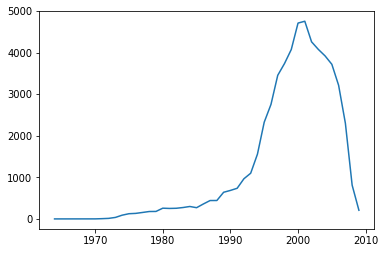

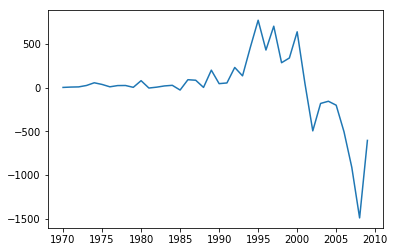

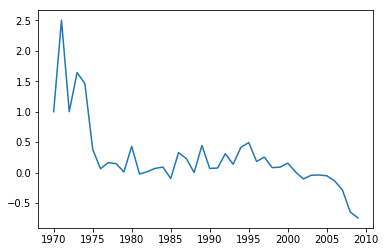

In [130]:
%matplotlib inline
pts.plot.line()
plt.show()
pts.diff().plot.line()
plt.show()
pts.pct_change().plot.line()
plt.show()

In [18]:
# 3. NAICS
p2["naics_name"].value_counts()

Computer and Peripheral Equipment    112198
Name: naics_name, dtype: int64

In [47]:
# 4. Merge with assignees
p2 = p2.merge(asg, how = "left", on = "patent")
del(asg)

# 5. Drop duplicate assignees
s_asg = p2[["assignee_id", "appyear"]].drop_duplicates("assignee_id", keep="first")

# 6. Number of first assignees by year
sts = s_asg["appyear"].value_counts().sort_index()

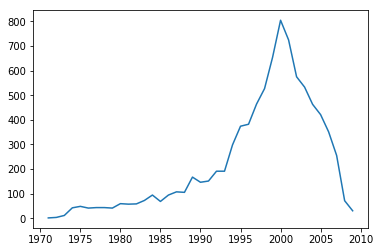

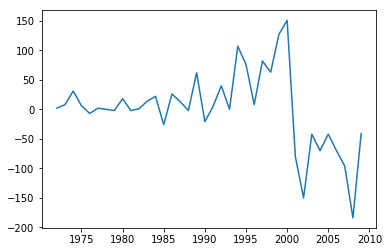

In [40]:
%matplotlib inline
sts.plot.line()
plt.show()
sts.diff().plot.line()
plt.show()

## 1. Location measures
### 1.1. Location distributions of new patents at each year

In [115]:
p3 = p2.loc[(p2["appyear"] >= 1985) & (p2["appyear"] <= 2005)]
ploc = p3[["inv_msa", "appyear", "patent"]].groupby(["inv_msa", "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 20]
ploc = ploc.pivot(index="appyear", columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

42


In [116]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(1985,2006)), index=list(range(1985,2006))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

In [117]:
# Timeline of lag1
sim1 = sim.loc[sim["lag"] == 1, ["appyear1", "sim_location"]].set_index("appyear1")

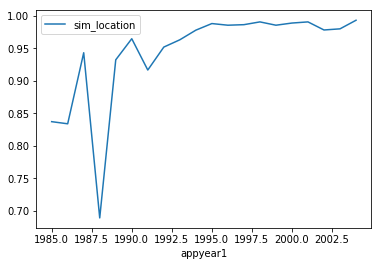

In [118]:
%matplotlib inline
# Plot
sim1.plot.line()

In [119]:
# Similarity to distribution at 1995 over time
sim2 = sim.loc[sim["appyear1"] == 1995, ["lag", "sim_location"]].set_index("lag")

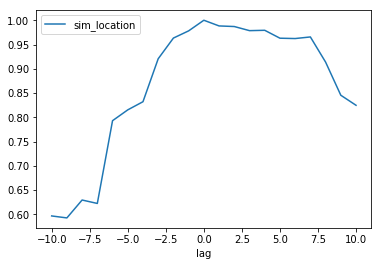

In [120]:
%matplotlib inline
# Plot
sim2.plot.line()

### 1.2 HHI for each year

In [121]:
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(1985,2006)))

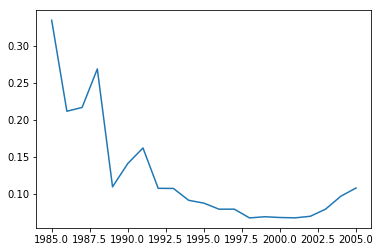

In [123]:
%matplotlib inline
# Plot
hhi.plot.line()

## 2. Similarity comparison of new patents 1995-6

### 2.1 First sample
Sampling procedure:
1. Get all new assignee patents 1995-96; get same number of existing assignee patents
2. For each patent, for each year: assign one patent from (a) same NAICS; (b) same primclass

In [135]:
# 1. Get new assignees 1995-6
n_asg = s_asg.loc[s_asg["appyear"].isin([1995,1996]), "assignee_id"].tolist()
p4 = p3.loc[p3["assignee_id"].isin(n_asg) & p3["appyear"].isin([1995,1996])]
print(len(p4))

1045


In [136]:
p5 = p3.loc[~p3["assignee_id"].isin(n_asg) & p3["appyear"].isin([1995,1996])]
print(len(p5))

4037


In [152]:
# Target patents
tp = p4[["patent", "primclass", "appyear"]].append(p5[["patent", "primclass", "appyear"]].sample(n=len(p4)))

# Times 10
tp2 = pd.DataFrame()
for i in range(30):
    tp2 = tp2.append(tp, ignore_index=True)
tp2["tp"] = tp2["patent"]
tp2 = tp2.drop("patent",1)
len(tp2)

62700

In [138]:
# NAICS patents; p3 is primclass patents
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
pn = pdf.loc[(pdf["appyear"] >= 1985) & (pdf["appyear"] <= 2005) & (pdf["naics_name"] == "Computer and Peripheral Equipment")]
del(pdf)

In [159]:
%%time
#NAICS Sample
png = pn[["patent", "appyear"]].groupby(["appyear"])
nsamp = pd.DataFrame()
for m,g in png:
    o = tp2
    g = g.loc[~g["patent"].isin(o["tp"])]
    o["op"] = g.sample(n = len(o), replace=True)["patent"].tolist()
    nsamp = nsamp.append(o, ignore_index=True)
nsamp.to_pickle("DataStore/2018-07-P2/Software/software_naics_0720.pkl")

CPU times: user 401 ms, sys: 29.5 ms, total: 431 ms
Wall time: 1.43 s


In [161]:
%%time
#Primclass Sample
png = p3[["patent", "appyear", "primclass"]].groupby(["appyear", "primclass"])
tpg = tp2.groupby("primclass")
psamp = pd.DataFrame()
for m,g in png:
    o = tpg.get_group(m[1])
    g = g.loc[~g["patent"].isin(o["tp"])]
    o["op"] = g.sample(n = len(o), replace=True)["patent"].tolist()
    psamp = psamp.append(o, ignore_index=True)
psamp.to_pickle("DataStore/2018-07-P2/Software/software_primclass_0720.pkl")

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 11.9 s, sys: 30.4 ms, total: 11.9 s
Wall time: 13.2 s


In [163]:
psamp.head()

,primclass,appyear,tp,op
0,700.0,1995.0,5495420,4630213
1,700.0,1995.0,5530962,4581699
2,700.0,1995.0,5544072,4727471
3,700.0,1996.0,5563802,4695941
4,700.0,1995.0,5568399,4729089


### 2.2 Second sample
- Compare software vs 701 & 702 navigational patents

In [164]:
# NAICS patents; p3 is primclass patents
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
p3 = pdf.loc[pdf["primclass"].isin([701,702])]
pn2 = pdf.loc[(pdf["appyear"] >= 1985) & (pdf["appyear"] <= 2005)\
              & (pdf["naics_name"] == "Navigational, Measuring, Electromedical, and Control Instruments")]
del(pdf)

In [ ]:
tp3 = p3.loc[p3["appyear"].isin([])]